In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data cleaning

In [166]:
from functions import clean_data

In [167]:
%autoreload
df_train = pd.read_csv("data/no1_train.csv")
df_test = pd.read_csv("data/no1_validation.csv")  # pd.read_csv("data/no1_test.csv")

# NEGATE FLOW
df_train["flow"] = -1.0 * df_train["flow"]
df_test["flow"] = -1.0 * df_test["flow"]


percent = 0.005
upper_bound = df_train.y.quantile(1-percent/2)
lower_bound = df_train.y.quantile(percent/2)

print("Upper bound:", upper_bound)
print("Lower bound:", lower_bound)


df_train = clean_data(df_train, upper_bound, lower_bound)
df_test = clean_data(df_test, upper_bound, lower_bound)

Upper bound: 1965.4099018235388
Lower bound: -876.8264394156931
Points clamped: 1126. In percent 0.5002%
Points clamped: 306. In percent 1.0876%


## Define features

In [168]:
df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,4417.4


In [169]:
from functions import add_structural_imbalance, add_time_features, add_lag_features

column_indcies = ['hydro', 'micro', 'thermal', 'wind', 'total',
        'sys_reg', 'flow', 'Minute sine', 'Minute cosine', 'Hour sine',
       'Hour cosine', 'Day sine', 'Day cosine', 'Month sine', 'Month cosine',
       'Week sine', 'Week cosine', 'prev_y_288', 'prev_y_1'] ## y should be last column,

lags = [1,12*24]
addNoise = True
lag_mean_prev_day = False
struc_imbalance = True

target_name = "y_struc_imb" if struc_imbalance else "y"
column_indcies.append(target_name)

df_train = add_time_features(df_train)
if struc_imbalance: df_train = add_structural_imbalance(df_train, feature_name=target_name) # new y = y_struc_imb
df_train = add_lag_features(df_train, feature=target_name, lags=lags, addNoise=addNoise, addMeanprevDay=lag_mean_prev_day)


df_test = add_time_features(df_test)
if struc_imbalance: df_test = add_structural_imbalance(df_test, feature_name=target_name)
df_test = add_lag_features(df_test, feature=target_name, lags=lags, addNoise=addNoise, addMeanprevDay=lag_mean_prev_day)

df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,...,Month sine,Month cosine,Week sine,Week cosine,total_interpolated,flow_interpolated,structural_imbalance,y_struc_imb,prev_y_1,prev_y_288
292,2019-01-10 14:30:00,2060.334,138.458,11.5,63.212,0.0,2273.504,326.137265,0.0,4236.4,...,0.5,0.866025,0.239316,0.970942,2273.503906,4236.399902,0.000191,326.137073,329.869333,269.199227
293,2019-01-10 14:35:00,2060.334,138.458,11.5,63.212,0.0,2273.504,291.972908,0.0,4236.4,...,0.5,0.866025,0.239316,0.970942,2273.641357,4245.435547,-9.172904,301.145812,325.957568,251.559695
294,2019-01-10 14:40:00,2060.334,138.458,11.5,63.212,0.0,2273.504,268.461842,0.0,4236.4,...,0.5,0.866025,0.239316,0.970942,2274.247559,4254.811035,-19.154594,287.616436,300.715347,257.245414
295,2019-01-10 14:45:00,2060.334,138.458,11.5,63.212,0.0,2273.504,233.799615,0.0,4236.4,...,0.5,0.866025,0.239316,0.970942,2275.253662,4264.382812,-29.732475,263.532090,288.416892,233.237611
296,2019-01-10 14:50:00,2060.334,138.458,11.5,63.212,0.0,2273.504,216.108615,0.0,4236.4,...,0.5,0.866025,0.239316,0.970942,2276.590332,4274.006836,-40.693168,256.801783,262.607250,229.433675


In [176]:
## Selectes only the wanted features
train_data = df_train[column_indcies]
test_data = df_test[column_indcies]
train_data.head()

,hydro,micro,thermal,wind,total,sys_reg,flow,Minute sine,Minute cosine,Hour sine,Hour cosine,Day sine,Day cosine,Month sine,Month cosine,Week sine,Week cosine,prev_y_288,prev_y_1,y_struc_imb
292,2060.334,138.458,11.5,63.212,2273.504,0.0,4236.4,5.665539e-16,-1.000000e+00,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,269.199227,329.869333,326.137073
293,2060.334,138.458,11.5,63.212,2273.504,0.0,4236.4,-5.000000e-01,-8.660254e-01,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,251.559695,325.957568,301.145812
294,2060.334,138.458,11.5,63.212,2273.504,0.0,4236.4,-8.660254e-01,-5.000000e-01,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,257.245414,300.715347,287.616436
295,2060.334,138.458,11.5,63.212,2273.504,0.0,4236.4,-1.000000e+00,-1.836970e-16,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,233.237611,288.416892,263.532090
296,2060.334,138.458,11.5,63.212,2273.504,0.0,4236.4,-8.660254e-01,5.000000e-01,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,229.433675,262.607250,256.801783


In [177]:
%autoreload
from functions import WindowGenerator, build_model, fit_and_plot
generator = WindowGenerator(train_data=train_data[-12*24*15:], test_data=test_data[:12*24*15] , target=target_name,
							n_input=12*24, n_output=1, shift=1, num_predictions=12*2, batch_size=32)

generator.getTrainData()

<MapDataset element_spec=(TensorSpec(shape=(None, 288, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [178]:
model = build_model(generator.getInputShape(), load_prev_model=False)
#model = build_model(load_prev_model="model_weights/lstm_512_epochs20_alldata.h5")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 128)               57216     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 57,345
Trainable params: 57,345
Non-trainable params: 0
_________________________________________________________________


In [179]:
# Shuffeles data
model = fit_and_plot(model, generator.getTrainData(), generator.getTestData(), epochs=4)

Epoch 1/4
 39/126 [========>.....................] - ETA: 15s - loss: 0.6601 - mean_absolute_error: 0.6135

KeyboardInterrupt: 

In [ ]:
model = fit_and_plot(model, generator.getTrainData(), generator.getTestData(), epochs=5)

100%|██████████| 23/23 [00:01<00:00, 20.14it/s]


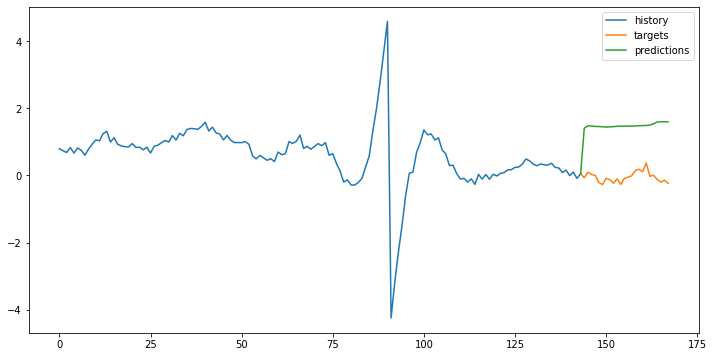

100%|██████████| 23/23 [00:01<00:00, 20.65it/s]


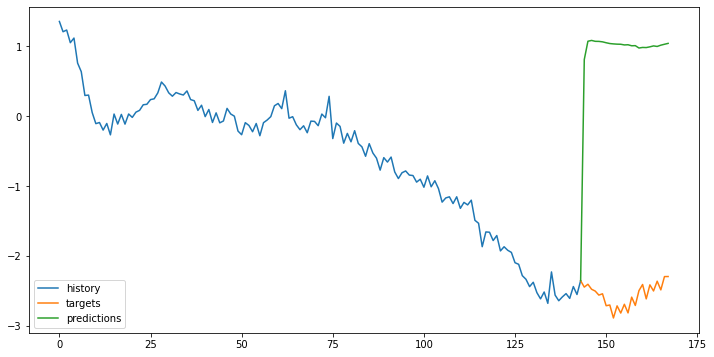

100%|██████████| 23/23 [00:01<00:00, 20.36it/s]


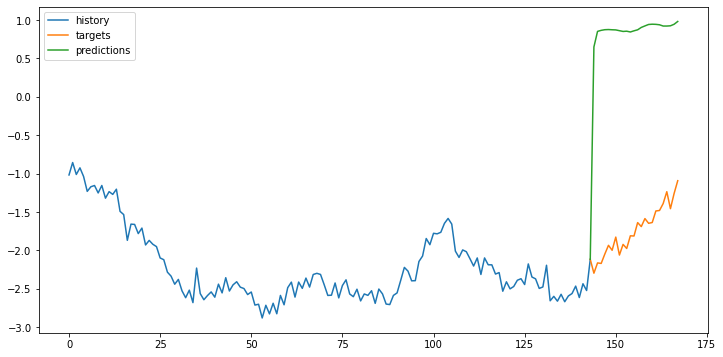

100%|██████████| 23/23 [00:01<00:00, 21.04it/s]


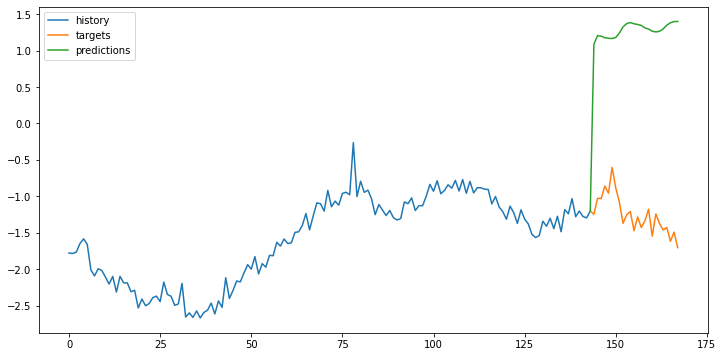

100%|██████████| 23/23 [00:01<00:00, 20.60it/s]


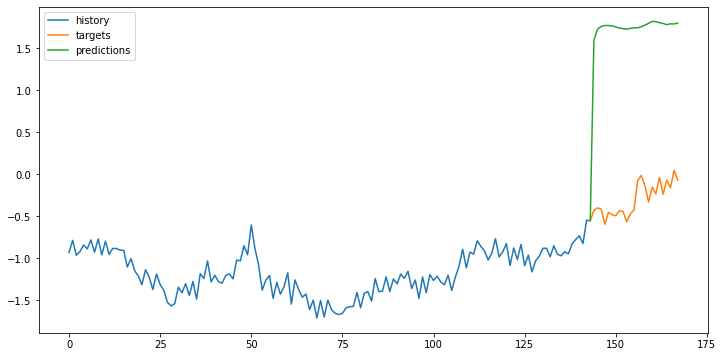

100%|██████████| 23/23 [00:01<00:00, 16.40it/s]


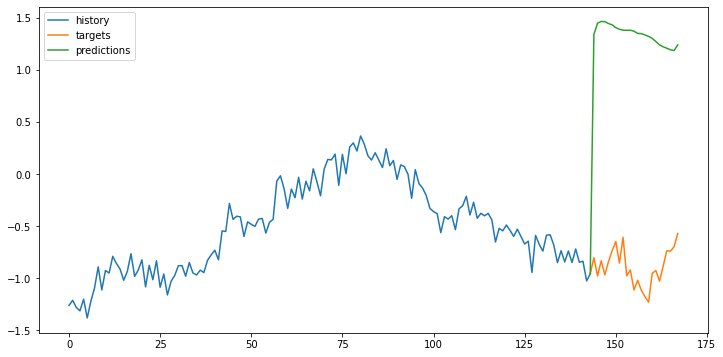

100%|██████████| 23/23 [00:01<00:00, 20.76it/s]


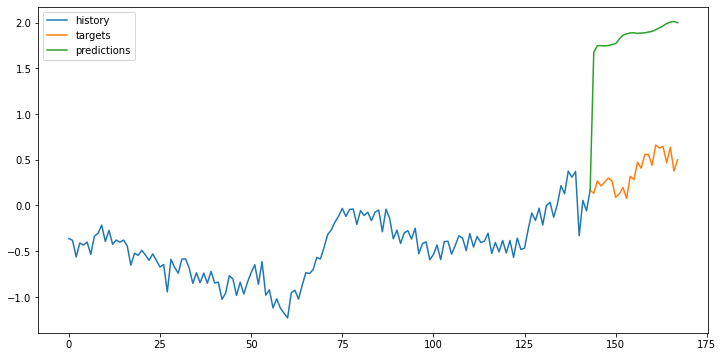

100%|██████████| 23/23 [00:01<00:00, 18.51it/s]


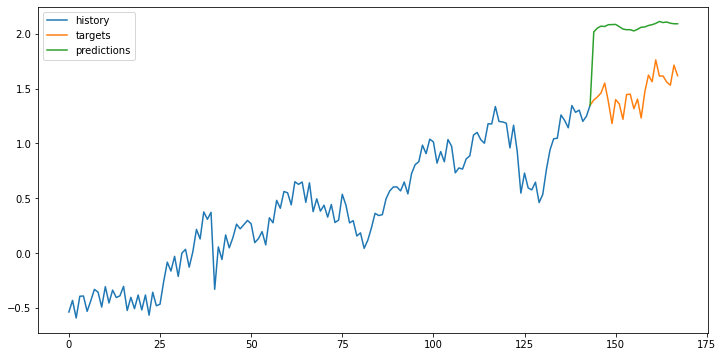

In [157]:
model.load_weights("model_weights/checkpoints/cp-0002.ckpt")
generator.predict_and_plot(model, data_raw=test_data, start_positions=[0,100, 200, 300, 400, 500, 600, 700], save_plot=False)

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
